In [1]:
import os
import pandas as pd
import geopandas as gp
pd.set_option('display.max_columns', None)


#Step 0: Load in ward shapefile and ER as gdf/df
mar23 = gp.read_file("./raw-from-source/WI_Statewide_WardsMar10_2023/Statewide_WardsMar10_2023.shp")

er = pd.read_excel("./raw-from-source/Ward by Ward Report statewide contests.xlsx", sheet_name=2, header=9)
er.rename( columns={'Unnamed: 0':'county', 'Unnamed: 1':'RU', 'Unnamed: 2':'tot_votes'}, inplace=True )
er = er[er["RU"]!="County Totals:"]

In [2]:
mar23["CTV"] = mar23["LABEL"].str.split(" ").str[-2]
mar23["MCD_NAME"] = mar23["LABEL"].str.split(" ").str[0:-3].apply(lambda x: " ".join(x)).str.upper()
wards22=mar23.copy()
wards22["county_mcd_ward"] = wards22["CNTY_NAME"].str.upper()+";"+wards22["CTV"].apply(lambda x: {"C":"CITY OF ", "V":"VILLAGE OF ", "T":"TOWN OF "}.get(x))+wards22["MCD_NAME"].str.upper()+";"+wards22["WARD_FIPS"].str.slice(start=-3)


er["county"] = er["county"].str.rstrip(" ")
er["ward_range"] = er["RU"].str.split(" ").str[-1]
er["mcd_str"] = er["RU"].str.split(" ").str[0:-2].apply(lambda x: " ".join(x)).str.upper()
er["county_mcd"] = er["county"]+";"+er["mcd_str"]
er["county_mcd_ward"] = er["county"]+";"+er["mcd_str"]+";"+er["ward_range"]

ward_dict={}
for ru in er["county_mcd_ward"]:
    county_str = er.loc[er["county_mcd_ward"]==ru, "county"].to_string(index=False)
    mcd_str =  er.loc[er["county_mcd_ward"]==ru, "mcd_str"].to_string(index=False).upper()
    #print("RU: ",ru)
    input_wards = ru.split(";")[-1]
    
    if "," in ru.split(";")[-1] and "-" not in ru.split(";")[-1]:
        for x in list(input_wards.split(",")):
            ward_id_str = county_str+";"+mcd_str+";"+str(x).zfill(3)
            ward_dict[ward_id_str] = ru
            #print(ward_id_str, ":", ru)
    elif ('2A' in ru.split(";")[-1]) or ('2B' in ru.split(";")[-1]):
        ward_dict[ru] = ru
        
    elif "-" in ru.split(";")[-1] and "," not in ru.split(";")[-1]:
        i = input_wards.split("-")[0]
        j = input_wards.split("-")[1]
        for x in range(int(i), int(j)+1):
            ward_id_str = county_str+";"+mcd_str+";"+str(x).zfill(3)
            ward_dict[ward_id_str] = ru
            #print(ward_id_str, ":", ru)
    elif "," in ru.split(";")[-1] and "-" in ru.split(";")[-1]:
        for item in list(input_wards.split(",")):
            #print("item: ", item)
            if "-" in item:
                i = item.split("-")[0]
                j = item.split("-")[1]
                #print("i, j:", i, j)
                for x in range(int(i), int(j)+1):
                    ward_id_str = county_str+";"+mcd_str+";"+str(x).zfill(3)
                    ward_dict[ward_id_str] = ru
                    #print(ward_id_str, ":", ru)
            else:
                x = item
                ward_id_str = county_str+";"+mcd_str+";"+str(x).zfill(3)
                ward_dict[ward_id_str] = ru
                #print(ward_id_str, ":", ru)
    else:
        x = input_wards
        ward_id_str = county_str+";"+mcd_str+";"+str(x).zfill(3)
        ward_dict[ward_id_str] = ru
        #print(ward_id_str, ":", ru)

        
ward_dict['BAYFIELD;TOWN OF GRANDVIEW;001']= 'BAYFIELD;TOWN OF GRAND VIEW;1'
ward_dict['CRAWFORD;VILLAGE OF MOUNT STERLING;001'] = 'CRAWFORD;VILLAGE OF MT. STERLING;1'
ward_dict['SAUK;VILLAGE OF LA VALLE;001'] = 'SAUK;VILLAGE OF LAVALLE;1'
ward_dict["VILAS;TOWN OF LAND O'LAKES;001"] = 'VILAS;TOWN OF LAND O-LAKES;1-2'
ward_dict["VILAS;TOWN OF LAND O'LAKES;002"] = 'VILAS;TOWN OF LAND O-LAKES;1-2'
ward_dict['WALWORTH;VILLAGE OF FONTANA-ON-GENEVA LAKE;001'] = 'WALWORTH;VILLAGE OF FONTANA;1-3'
ward_dict['WALWORTH;VILLAGE OF FONTANA-ON-GENEVA LAKE;002'] = 'WALWORTH;VILLAGE OF FONTANA;1-3'
ward_dict['WALWORTH;VILLAGE OF FONTANA-ON-GENEVA LAKE;003'] = 'WALWORTH;VILLAGE OF FONTANA;1-3'
ward_dict['WAUPACA;TOWN OF ST. LAWRENCE;001'] = 'WAUPACA;TOWN OF SAINT LAWRENCE;1-2'
ward_dict['WAUPACA;TOWN OF ST. LAWRENCE;002'] = 'WAUPACA;TOWN OF SAINT LAWRENCE;1-2'
ward_dict['WINNEBAGO;TOWN OF WOLF RIVER;02A'] = 'WINNEBAGO;TOWN OF WOLF RIVER;1-2A'
ward_dict['CHIPPEWA;CITY OF CHIPPEWA FALLS;007'] = 'CHIPPEWA;CITY OF CHIPPEWA FALLS;8-7'
ward_dict['CHIPPEWA;CITY OF CHIPPEWA FALLS;008'] = 'CHIPPEWA;CITY OF CHIPPEWA FALLS;8-7'

ward_dict['CHIPPEWA;CITY OF CHIPPEWA FALLS;01A'] = 'CHIPPEWA;CITY OF CHIPPEWA FALLS;1-2'
ward_dict['CHIPPEWA;CITY OF CHIPPEWA FALLS;10A'] = 'CHIPPEWA;CITY OF CHIPPEWA FALLS;9-10'
ward_dict['CHIPPEWA;TOWN OF EAGLE POINT;05A'] = 'CHIPPEWA;TOWN OF EAGLE POINT;1-5'
ward_dict['MILWAUKEE;CITY OF WAUWATOSA;02A'] = 'MILWAUKEE;CITY OF WAUWATOSA;2A'
ward_dict['MILWAUKEE;CITY OF WAUWATOSA;02B'] = 'MILWAUKEE;CITY OF WAUWATOSA;2B'

ward_dict['OZAUKEE;CITY OF MEQUON;02A'] = 'OZAUKEE;CITY OF MEQUON;1-3'
ward_dict['OZAUKEE;CITY OF MEQUON;11A'] = 'OZAUKEE;CITY OF MEQUON;9-11'

ward_dict['WINNEBAGO;TOWN OF WOLF RIVER;001'] = 'WINNEBAGO;TOWN OF WOLF RIVER;1-2B'
ward_dict['WINNEBAGO;TOWN OF WOLF RIVER;02B'] = "WINNEBAGO;TOWN OF WOLF RIVER;1-2B"

ward_dict['CALUMET;TOWN OF HARRISON;001'] = "CALUMET;TOWN OF HARRISON;001"
ward_dict["DANE;TOWN OF COTTAGE GROVE;1,2,3,4,5,6"]="DANE;CITY OF MADISON;156"


#Step 3: Apply ward:RU dictionary to ward gdf
wards22["RU_assignment"] = wards22["county_mcd_ward"].map(ward_dict)
gdf_wards_with_match = wards22[~wards22["RU_assignment"].isna()]

#Step 4: Check if any wards do not have valid RU assignment
gdf_wards_no_match = wards22[wards22["RU_assignment"].isna()]
print("Shape wards no match df: ", gdf_wards_no_match.shape)

#Step 5: Test join dissolved gdf<>df
ru_gdf = gdf_wards_with_match.dissolve(by="RU_assignment").reset_index().to_crs(wards22.crs)
er.loc[er["RU"]=="City of MADISON Ward 156", "county_mcd_ward"] = "DANE;TOWN OF COTTAGE GROVE;1,2,3,4,5,6"
prelim_shp_atger_gdf = ru_gdf.merge(er, how="outer", left_on="RU_assignment", right_on="county_mcd_ward", indicator=True)
print("Wards not assigned: ",wards22["RU_assignment"].isna().shape,"\nWards with match shape: ", gdf_wards_with_match.shape, "\nFrom what should match, did not join: ", prelim_shp_atger_gdf[prelim_shp_atger_gdf["_merge"]!="both"].shape)


Shape wards no match df:  (0, 16)
Wards not assigned:  (7008,) 
Wards with match shape:  (7008, 16) 
From what should match, did not join:  (2, 27)


In [3]:
gdf_wards_no_match

,CNTY_FIPS,CNTY_NAME,COUSUBFP,WARD_FIPS,WARDID,SUPERID,ALDERID,LABEL,CON2021,ASM2021,SEN2021,geometry,CTV,MCD_NAME,county_mcd_ward,RU_assignment


In [4]:
set(wards22["county_mcd_ward"])-set(ward_dict.keys())

set()

In [5]:
prelim_shp_atger_gdf[prelim_shp_atger_gdf["_merge"]!="both"]

,RU_assignment,geometry,CNTY_FIPS,CNTY_NAME,COUSUBFP,WARD_FIPS,WARDID,SUPERID,ALDERID,LABEL,CON2021,ASM2021,SEN2021,CTV,MCD_NAME,county_mcd_ward_x,county,RU,tot_votes,Janet C. Protasiewicz,Daniel Kelly,SCATTERING,ward_range,mcd_str,county_mcd,county_mcd_ward_y,_merge
280,CALUMET;TOWN OF HARRISON;001,"POLYGON ((-88.39786 44.21431, -88.39786 44.213...",55015,Calumet,32800,55015328000001,0001,09,None,HARRISON - T 0001,8,3,1,T,HARRISON,CALUMET;TOWN OF HARRISON;001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3596,WINNEBAGO;TOWN OF WOLF RIVER;1-2A,"POLYGON ((-88.76605 44.23967, -88.76600 44.238...",55139,Winnebago,88475,5513988475002A,002A,36,None,WOLF RIVER - T 002A,6,55,19,T,WOLF RIVER,WINNEBAGO;TOWN OF WOLF RIVER;02A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [6]:
gdf = prelim_shp_atger_gdf.copy()

In [7]:
gdf["CON2021"][gdf["mcd_str"]=="CITY OF MADISON"].value_counts()

CON2021
2    156
Name: count, dtype: int64

In [8]:
gdf["CON2021"][gdf["mcd_str"]=="TOWN OF COTTAGE GROVE"].value_counts()

CON2021
2    1
Name: count, dtype: int64

In [9]:
gdf["ASM2021"][gdf["mcd_str"]=="TOWN OF COTTAGE GROVE"].value_counts()

ASM2021
46    1
Name: count, dtype: int64

In [10]:
gdf["SEN2021"][gdf["mcd_str"]=="TOWN OF COTTAGE GROVE"].value_counts()

SEN2021
16    1
Name: count, dtype: int64

<AxesSubplot:>

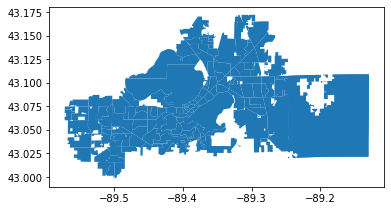

In [11]:
gdf[(gdf["mcd_str"]=="CITY OF MADISON")|(gdf["mcd_str"]=="TOWN OF COTTAGE GROVE")].plot()

<AxesSubplot:>

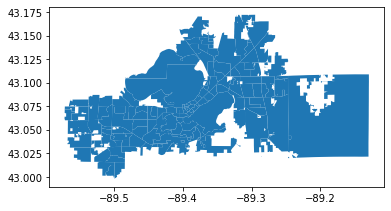

In [12]:
gdf[(gdf["mcd_str"]=="CITY OF MADISON")].plot()

In [13]:
cong = prelim_shp_atger_gdf[['CON2021','tot_votes', 'Janet C. Protasiewicz', 'Daniel  Kelly','SCATTERING']].groupby("CON2021").sum().reset_index()
sldu = prelim_shp_atger_gdf[['SEN2021','tot_votes', 'Janet C. Protasiewicz', 'Daniel  Kelly','SCATTERING']].groupby("SEN2021").sum().reset_index()
sldl = prelim_shp_atger_gdf[['ASM2021','tot_votes', 'Janet C. Protasiewicz', 'Daniel  Kelly','SCATTERING']].groupby("ASM2021").sum().reset_index()

In [14]:
def statewide_totals_check(partner_df, partner_name, source_df, source_name, column_list):
    """Compares the totals of two election result dataframes at the statewide total level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
 
    Returns:
      difference list
    """
    print("***Statewide Totals Check***")
    diff_races=[]
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            if race not in diff_races:
                diff_races.append(race)
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\t"+ partner_name + ": "+str(partner_df[race].sum())+" votes")
            print("\t"+ source_name +": "+str(source_df[race].sum())+" votes")
        #else:
            #print(race + " is equal", "\t both dataframes " + str(partner_df[race].sum()))
    
    if (len(diff_races)==0):
        print("All contests match statewide!")
    elif (len(diff_races)>0):
        print("Contests with differences: ")
    
    return diff_races


def county_totals_check(partner_df, partner_name, source_df, source_name, column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      partner_name: String of what to call the partner in the print statement
      source_df: DataFrame of election results we are comparing to
      source_name: String of what to call the source in the print statement
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      difference list
    """
    
    print("\n***Countywide Totals Check***")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race, " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t",val," has a difference of ",str(county_differences[val])," votes")
                print("\t\t", partner_name , ": ",str(partner_df.groupby([county_col]).sum().loc[val,race])," votes")
                print("\t\t", source_name ,": ",str(source_df.groupby([county_col]).sum().loc[val,race])," votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t",val , ": ", str(partner_df.groupby([county_col]).sum().loc[val,race])," votes")
        #else:
            #print(race + " is equal across all counties")
            #if (full_print):
               # for val in diff[diff == 0].index.values.tolist():
                 #   county_similarities = diff[diff == 0]
                    #print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
    if (len(diff_counties)==0):
        print("All contests in all counties match!")
    elif (len(diff_counties)>0):
        print("Counties with differences: ")
        
    return diff_counties

print("USING COUNTY CHECK CODE TO CHECK DISTRICT LEVEL RESULTS, IGNORE COUNTY REFERENCE")
print("\ncheck congressional level results")
statewide_totals_check(cong, "rdh", gdf[["CON2021",'Janet C. Protasiewicz', 'Daniel  Kelly']], "WI", ['Janet C. Protasiewicz', 'Daniel  Kelly'])
county_totals_check(cong, "rdh", gdf[["CON2021",'Janet C. Protasiewicz', 'Daniel  Kelly']], "WI", ['Janet C. Protasiewicz', 'Daniel  Kelly'],"CON2021",full_print=False)
print("\ncheck state assembly level results")
statewide_totals_check(sldl, "rdh", gdf[["ASM2021",'Janet C. Protasiewicz', 'Daniel  Kelly']], "WI", ['Janet C. Protasiewicz', 'Daniel  Kelly'])
county_totals_check(sldl, "rdh", gdf[["ASM2021",'Janet C. Protasiewicz', 'Daniel  Kelly']], "WI", ['Janet C. Protasiewicz', 'Daniel  Kelly'],"ASM2021",full_print=False)
print("\ncheck state senate level results")
statewide_totals_check(sldu, "rdh", gdf[["SEN2021",'Janet C. Protasiewicz', 'Daniel  Kelly']], "WI", ['Janet C. Protasiewicz', 'Daniel  Kelly'])
county_totals_check(sldu, "rdh", gdf[["SEN2021",'Janet C. Protasiewicz', 'Daniel  Kelly']], "WI", ['Janet C. Protasiewicz', 'Daniel  Kelly'],"SEN2021",full_print=False)

USING COUNTY CHECK CODE TO CHECK DISTRICT LEVEL RESULTS, IGNORE COUNTY REFERENCE

check congressional level results
***Statewide Totals Check***
All contests match statewide!

***Countywide Totals Check***
All contests in all counties match!

check state assembly level results
***Statewide Totals Check***
All contests match statewide!

***Countywide Totals Check***
All contests in all counties match!

check state senate level results
***Statewide Totals Check***
All contests match statewide!

***Countywide Totals Check***
All contests in all counties match!


[]

In [18]:
#os.mkdir("./wi_ssc_23/")
cong.to_csv("./wi_ssc_23/wi_ssc_23_cong.csv", index=False)
sldu.to_csv("./wi_ssc_23/wi_ssc_23_sldu.csv", index=False)
sldl.to_csv("./wi_ssc_23/wi_ssc_23_sldl.csv", index=False)

In [ ]:
cong.columns

For readme:
- Note "DANE;TOWN OF COTTAGE GROVE;1,2,3,4,5,6" assigned 4 votes before aggregating to district level from "DANE;CITY OF MADISON;156" from the election results as per [WI Ordinances page](https://mds.wi.gov/View/Ordinances)



Wisconsin 2023 State Supreme Court Election results aggregated to CONG, SLDL and SLDU levels

## Redistricting Data Hub (RDH) Retrieval Date
12/12/2023

## Sources
The RDH retrieved 2023 State Supreme Court reporting unit level election results from the Wisconsin Election Commission (https://elections.wi.gov/elections/election-results) 
2023 ward boundaries were retrieved from the Wisconsin Election Commission upon request. Please see "Additional Notes" below for more information on this unofficial file.

## Fields
Field                   Description

*all files*
tot_votes               total votes for unit geography
Janet C. Protasiewicz   total votes assigned to Janet C. Protasiewicz per unit geography
Daniel  Kelly           total votes assigned to Daniel  Kelly per unit geography
SCATTERING              write in candidate votes

*congressional file*
CON2021                 2021 congressional district
*SLDL file*
ASM2021                 2021 state assembly district
*SLDU file*
SEN2021                 2021 state senate district


## Processing Steps
The RDH aggregated the above and below mentioned ward boundary shapefile to the reporting unit level. This ward shapefile also had assignments for congressional and state legislative districts from the 2021 boundaries. The reporting unit identifiers were used to join to the 2023 State Supreme Court Election results at the Reporting Unit level, then the district assignments were used to aggregate to the congressional and state legislative levels.

## Additional Notes

On wards/reporting units:
Wisconsin reports votes at the "Reporting Unit" level. Reporting Units are made up of collections of redistricting wards. From the Wisconsin Election commission website, "Wards are the building blocks from which congressional, state senate, assembly, county supervisory and aldermanic districts are created. All territory, even if unpopulated, must be contained in a ward... Election results are reported by “reporting units.” A reporting unit may be one ward or a group of wards combined by resolution of the governing body" (https://elections.wi.gov/wards-districts-and-reporting-units)

On ward boundaries:
Wisconsin releases official ward boundary files in July and January of every year to reflect all updates and ordinances that have occurred since the prior release. As a result, the ward boundaries in the official files do not necessarily reflect the boundaries that were in place for any given election. 


Wisconsin's official January 2023 file is available from the [LTSBE](https://data-ltsb.opendata.arcgis.com/datasets/LTSB), and ward boundary changes are tracked by the Municipal Boundary Review team on the state's [ordinances page](https://mds.wi.gov/View/Ordinances). Because of the boundary changes that occurred between January 2023 and April 2023, the RDH requested a file that would more accurately reflect the boundaries that were in place at the time of the election from the Wisconsin Election Commission. The Wisconsin Election Commission provided an *unofficial* file reflecting the boundaries in place in March of 2023. 

When comparing aggregated wards from the ward boundary file to the ward aggregates listed as reporting units from the election result files there was almost a complete match. Of note, The City of Madison Ward #156 in Dane County had results - 4 votes for Janet C. Protasiewicz in the election results, but no corresponding ward in the ward boundary file. Based on the [Ordinances page](https://mds.wi.gov/View/Ordinances) the RDH assigned this ward with the Town of Cottage Grove in Dane County as a best guess match. 

For questions about this dataset please contact info@redistrictingdatahub.org 